In [1]:
from luxai_s2.env import LuxAI_S2
from luxai_s2.map.board import Board
from luxai_s2.state import State
from luxai_s2.map_generator.generator import GameMap
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def reset_w_custom_board(environment, seed, custom_board):
    environment.agents = environment.possible_agents[:]
    environment.env_steps = 0
    if seed is not None:
        environment.seed_val = seed
        environment.seed_rng = np.random.RandomState(seed=seed)
    else:
        environment.seed_val = np.random.randint(0, 2**32 - 1)
        environment.seed_rng = np.random.RandomState(seed=environment.seed_val)
    
    environment.state: State = State(
        seed_rng=environment.seed_rng,
        seed=environment.seed_val,
        env_cfg=environment.state.env_cfg,
        env_steps=0,
        board=custom_board,
    )
        
    environment.max_episode_length = environment.env_cfg.max_episode_length
    for agent in environment.possible_agents:
        environment.state.units[agent] = OrderedDict()
        environment.state.factories[agent] = OrderedDict()
        if environment.collect_stats:
            environment.state.stats[agent] = create_empty_stats()
    obs = environment.state.get_obs()
    observations = {agent: obs for agent in environment.agents}
    return observations, environment

In [3]:
# key-values of dict below should match attributes present in this class
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/config.py#L34
environment_config = dict(
        max_episode_length=350,  # how many total turns in game
        CYCLE_LENGTH=50,
        DAY_LENGTH=50,  # so no night
        MAX_RUBBLE=0,  # disable rubble   
    )
env = LuxAI_S2(**environment_config)
custom_rubble = np.zeros((env.env_cfg.map_size,) * 2, dtype=np.int64)

# Let's put a single ice at 30,30
custom_ice = np.zeros_like(custom_rubble)
custom_ice[30, 30] = 1

# Let's put a single ore at 40, 40
custom_ore = np.zeros_like(custom_rubble)
custom_ore[40, 40] = 1

custom_symmetry = None
custom_map_ = GameMap(custom_rubble, custom_ice, custom_ore, custom_symmetry)

simple_board = Board(
    seed=env.seed_rng.randint(0, 2**32 - 1, dtype=np.int64), 
    env_cfg=env.env_cfg,
    existing_map=custom_map_
)

obs, env = reset_w_custom_board(env, seed=41, custom_board=simple_board)
    
# source code of reset() method: 
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/env.py#L175
# obs = env.reset(seed=41) # resets an environment with a seed

In [4]:
import matplotlib
matplotlib.rc('font', size=14)

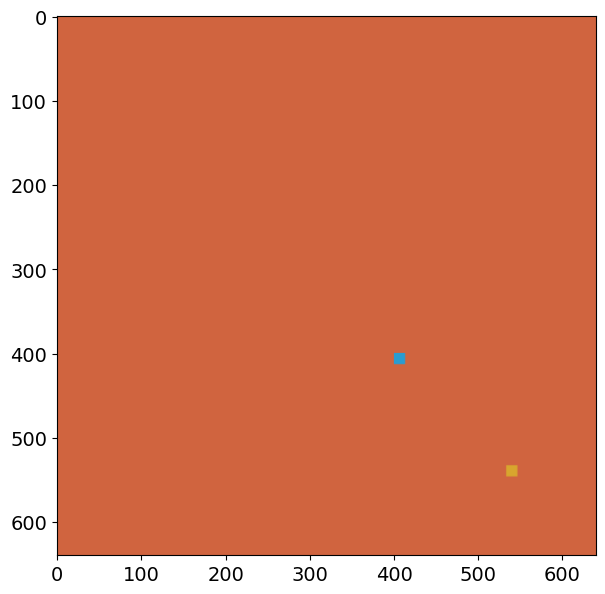

In [5]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [6]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

In [7]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, env = reset_w_custom_board(env, seed=41, custom_board=simple_board)
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

In [8]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        
        # how much water and metal you have in your starting pool to give to new factories
        water_left = game_state.teams[self.player].water
        metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
            spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
            return dict(spawn=spawn_loc, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

In [9]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 5)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [10]:
from lux.kit import obs_to_game_state, GameState

In [11]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
    return actions
Agent.act = act

In [12]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [13]:
from lux.utils import direction_to
import sys
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
            
    # iterate over our units and have them mine the closest ice tile
    units = game_state.units[self.player]
    ice_map = game_state.board.ice # flip the board as it stores by rows then columns
    ice_tile_locations = np.argwhere(ice_map == 1) # numpy magic to get the position of every ice tile
    for unit_id, unit in units.items():
        # compute the distance to each ice tile from this unit and pick the closest
        ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
        closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
        
        # if we have reached the ice tile, start mining if possible
        if np.all(closest_ice_tile == unit.pos):
            if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.dig(repeat=0)]
        else:
            direction = direction_to(unit.pos, closest_ice_tile)
            move_cost = unit.move_cost(game_state, direction)
            # check move_cost is not None, meaning that direction is not off the map or blocked
            # check if unit has enough power to move in addition to updating the action queue.
            if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.move(direction, repeat=0)]
        # since we are using the simple embedded visualizer, we will have to print out details about units
        # importantly, note that we print with file=sys.stderr. Printing with anything will cause your agent to fail
        if unit.cargo.ice > 50:
            print(game_state.real_env_steps, unit, f"has {unit.cargo.ice} ice", file=sys.stderr)
    return actions
Agent.act = act

In [14]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=40)

5: 2 Units: (unit_14, unit_9) collided at 31,31
7: 1 Units: (unit_10) collided at 25,9 with [0] unit_8 UnitType.HEAVY at (25, 9) surviving with 360 power


18 [1] unit_12 HEAVY at [30 30] has 60 ice
19 [1] unit_12 HEAVY at [30 30] has 60 ice
20 [1] unit_12 HEAVY at [30 30] has 60 ice
21 [1] unit_12 HEAVY at [30 30] has 80 ice
22 [1] unit_12 HEAVY at [30 30] has 80 ice
23 [1] unit_12 HEAVY at [30 30] has 80 ice
24 [1] unit_12 HEAVY at [30 30] has 80 ice
25 [1] unit_12 HEAVY at [30 30] has 80 ice
26 [1] unit_12 HEAVY at [30 30] has 80 ice
27 [1] unit_12 HEAVY at [30 30] has 80 ice
28 [1] unit_12 HEAVY at [30 30] has 100 ice
29 [1] unit_12 HEAVY at [30 30] has 100 ice
30 [1] unit_12 HEAVY at [30 30] has 100 ice
OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [15]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    for unit_id, unit in units.items():
        
        # track the closest factory
        closest_factory = None
        adjacent_to_factory = False
        if len(factory_tiles) > 0:
            factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
            closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
            closest_factory = factory_units[np.argmin(factory_distances)]
            adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
            # previous ice mining code
            if unit.cargo.ice < 40:
                ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                if np.all(closest_ice_tile == unit.pos):
                    if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.dig(repeat=0)]
                else:
                    direction = direction_to(unit.pos, closest_ice_tile)
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
            # else if we have enough ice, we go back to the factory and dump it.
            elif unit.cargo.ice >= 40:
                direction = direction_to(unit.pos, closest_factory_tile)
                if adjacent_to_factory:
                    if unit.power >= unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                else:
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
    return actions
Agent.act = act

In [16]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 300)

5: 1 Units: (unit_15) collided at 36,24 with [0] unit_8 UnitType.HEAVY at (36, 24) surviving with 400 power
12: 1 Units: (unit_13) collided at 33,28 with [0] unit_8 UnitType.HEAVY at (33, 28) surviving with 260 power
14: Invalid movement action for unit [0] unit_10 UnitType.HEAVY at (17, 16) - Tried to move to (17, 17) which is on an opponent factory
15: Invalid movement action for unit [0] unit_10 UnitType.HEAVY at (17, 16) - Tried to move to (17, 17) which is on an opponent factory
16: Invalid movement action for unit [0] unit_10 UnitType.HEAVY at (17, 16) - Tried to move to (17, 17) which is on an opponent factory
16: 1 Units: (unit_11) collided at 28,32 with [1] unit_12 UnitType.HEAVY at (28, 32) surviving with 180 power
17: Invalid movement action for unit [0] unit_10 UnitType.HEAVY at (17, 16) - Tried to move to (17, 17) which is on an opponent factory
17: 1 Units: (unit_12) collided at 30,30 with [0] unit_8 UnitType.HEAVY at (30, 30) surviving with 160 power
18: Invalid movement

KeyError: 'unit_13'

In [ ]:
# %%writefile agent.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        for unit_id, unit in units.items():

            # track the closest factory
            closest_factory = None
            adjacent_to_factory = False
            if len(factory_tiles) > 0:
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
                closest_factory = factory_units[np.argmin(factory_distances)]
                adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0

                # previous ice mining code
                if unit.cargo.ice < 40:
                    ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                    closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                    if np.all(closest_ice_tile == unit.pos):
                        if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.dig(repeat=0)]
                    else:
                        direction = direction_to(unit.pos, closest_ice_tile)
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
                # else if we have enough ice, we go back to the factory and dump it.
                elif unit.cargo.ice >= 40:
                    direction = direction_to(unit.pos, closest_factory_tile)
                    if adjacent_to_factory:
                        if unit.power >= unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                    else:
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
        return actions